# 제목을 단어 단위로 분해한 데이터를 집계해 머신러닝 모델에 적용시키기

- 각 뉴스 기사의 제목을 따와 KoNLPy로 분해하기 (단어 단위)
- 각 단어를 하나의 컬럼명으로 지정한 새로운 테이블 word_count_t 생성
    - 각 레코드(행)는 뉴스 기사 하나의 데이터
    - 
- word_count_t의 앞쪽에 각 뉴스 기사의 날짜, 제목 컬럼을 추가

In [1]:
# 불필요한 경고 출력을 방지
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


## 데이터 읽기

In [3]:
df = pd.read_csv('../know_arc_pjt/data_crawling_D/data_crawling_김경민/cwn.kr/2023-06-20-16.csv')
print(df.shape)

(2220, 7)


## 데이터 형상 파악하기

In [4]:
df.head()


,news_date,news_title,news_text_sm,url_in,news_writer,tags_string,thumb_addr
0,2023.06.20 15:11,태양전지 같은 세계적 수준의 원천기술 확보에 성공,정부가 10년이 넘는 기간 동안 장기적으로 국내의 원천 기술을 확보하기 위해 지원한...,https://www.cwn.kr/news/articleView.html?idxno...,조하민,NaN,NaN
1,2023.06.20 14:42,中 ZTE 저가 스마트 글래스 ‘누비아 네오비전 글래스’ 정식 판매 개시,T3 GSM아레나 등 복수 외신은 중국 소비자 기기 제조사 ZTE가 스마트 글래스 ...,https://www.cwn.kr/news/articleView.html?idxno...,박채원,"#ZTE,#스마트 글래스,#누비아 네오비전 글래스",https://www.cwn.krhttps://cdn.cwn.kr/news/thum...
2,2023.06.19 18:23,인티그리트의 챗GPT 탑재한 로봇 로봇 구독 서비스(RaaS: Robot as a ...,로보틱스 플랫폼 전문기업 인티그리트(Integrit.ai)가 챗GPT 로봇 ‘GPT...,https://www.cwn.kr/news/articleView.html?idxno...,김지영,"#인티그리트,#GPT-플래티,#챗GPT,#AI,#인공지능,#로봇,#대규모 언어모델",https://www.cwn.krhttps://cdn.cwn.kr/news/thum...
3,2023.06.19 18:23,"英 연구팀 ""AI 생성 콘텐츠로 학습하는 AI 정보 왜곡 문제 악화할 것""",블록체인 전문 매체 디크립트가 인공지능(AI)이 생성한 콘텐츠로 학습하는 AI의 등...,https://www.cwn.kr/news/articleView.html?idxno...,최은희,"#인공지능,#AI,#생성형 AI,#알고리즘",https://www.cwn.krhttps://cdn.cwn.kr/news/thum...
4,2023.06.16 12:48,LG U+ 3GPP 워크숍 참가,LG유플러스는 이번 달 16일까지 ‘3GPP RAN 릴리즈19 워크숍’에 참가하기 ...,https://www.cwn.kr/news/articleView.html?idxno...,조하민,NaN,NaN


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_date     2220 non-null   object
 1   news_title    2220 non-null   object
 2   news_text_sm  2216 non-null   object
 3   url_in        2220 non-null   object
 4   news_writer   2220 non-null   object
 5   tags_string   2045 non-null   object
 6   thumb_addr    2195 non-null   object
dtypes: object(7)
memory usage: 121.5+ KB


In [6]:
df.describe()

,news_date,news_title,news_text_sm,url_in,news_writer,tags_string,thumb_addr
count,2220,2220,2216,2220,2220,2045,2195
unique,2196,2219,2216,2220,32,1777,2195
top,2022.04.08 13:55,[코딩 트렌드] C/C 4월 PyPL 인기 프로그래밍 언어 랭킹 5위...티오베...,정부가 10년이 넘는 기간 동안 장기적으로 국내의 원천 기술을 확보하기 위해 지원한...,https://www.cwn.kr/news/articleView.html?idxno...,고다솔,"#러스트,#코딩,#프로그래밍,#프로그래밍 언어",https://www.cwn.krhttps://cdn.cwn.kr/news/thum...
freq,3,2,1,1,473,14,1


In [7]:
df.columns


Index(['news_date', 'news_title', 'news_text_sm', 'url_in', 'news_writer',
       'tags_string', 'thumb_addr'],
      dtype='object')

## 날짜를 기준으로 정렬한 뒤 22-05-31 ~ 23-05-31 범위 내로 잘라 저장하기

In [8]:
# df의 news_date에서 '날짜 시간'에서 시간을 datetime64로
df['news_date'] = pd.to_datetime(df['news_date']) # datetime dtype으로 변환
df['news_date']

0      2023-06-20 15:11:00
1      2023-06-20 14:42:00
2      2023-06-19 18:23:00
3      2023-06-19 18:23:00
4      2023-06-16 12:48:00
               ...        
2215   2022-02-24 19:37:00
2216   2022-02-24 19:37:00
2217   2022-02-24 17:58:00
2218   2022-02-24 16:57:00
2219   2022-02-24 15:53:00
Name: news_date, Length: 2220, dtype: datetime64[ns]

In [9]:
df['news_date'] = df['news_date'].dt.strftime('%Y.%m.%d')
# 한번 실행하면 다시 실행할시 오류

In [10]:
df['news_date']


0       2023.06.20
1       2023.06.20
2       2023.06.19
3       2023.06.19
4       2023.06.16
           ...    
2215    2022.02.24
2216    2022.02.24
2217    2022.02.24
2218    2022.02.24
2219    2022.02.24
Name: news_date, Length: 2220, dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_date     2220 non-null   object
 1   news_title    2220 non-null   object
 2   news_text_sm  2216 non-null   object
 3   url_in        2220 non-null   object
 4   news_writer   2220 non-null   object
 5   tags_string   2045 non-null   object
 6   thumb_addr    2195 non-null   object
dtypes: object(7)
memory usage: 121.5+ KB


In [12]:
# news_date의 dtype을 datetime으로
df['news_date'] = pd.to_datetime(df['news_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   news_date     2220 non-null   datetime64[ns]
 1   news_title    2220 non-null   object        
 2   news_text_sm  2216 non-null   object        
 3   url_in        2220 non-null   object        
 4   news_writer   2220 non-null   object        
 5   tags_string   2045 non-null   object        
 6   thumb_addr    2195 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 121.5+ KB


In [13]:
# 2022-05-31
df_filtered = df[df['news_date'].between('2022-05-31', '2023-05-31')]
df_filtered

,news_date,news_title,news_text_sm,url_in,news_writer,tags_string,thumb_addr
45,2023-05-31,인기 안드로이드 앱 사용자 몰래 감시한 사실 뒤늦게 드러나,테크크런치 데일리메일 등 복수 외신은 사이버 보안 기업 이셋(ESET)의 조사 결과...,https://www.cwn.kr/news/articleView.html?idxno...,최은희,"#안드로이드,#안드로이드 앱,#멀웨어,#감시,#사이버 공격,#사이버 보안",https://www.cwn.kr/news/thumbnail/202305/16894...
46,2023-05-31,AI에게서 내 개인정보를 보호한다… 대학생이 개발한 AI 정보보호 서비스 ‘챗큐리티...,‘챗큐리티’가 데이터 검사를 진행하는 모습챗GPT(ChatGPT)나 구글 바드(Ba...,https://www.cwn.kr/news/articleView.html?idxno...,온라인뉴스팀,"#AI 정보보호 솔루션,#챗큐리티,#AI,#인공지능,#민감 정보 검사,#정보 보호,...",https://www.cwn.kr/news/thumbnail/202305/mn_16...
47,2023-05-31,“인공지능이 인류 종말 초래할 것”…전문가 집단 규제 촉구 공개서한 서명,30일(현지 시각) BBC 데일리메일 가디언 등 복수 외신은 테크 업계 전문가 35...,https://www.cwn.kr/news/articleView.html?idxno...,박채원,"#인공지능,#AI,#AI 규제,#챗GPT,#오픈AI,#샘 알트만",https://www.cwn.kr/news/thumbnail/202305/16888...
48,2023-05-31,뷰티 외식 브랜드 ‘엠제이부티끄’ 블록체인 프로젝트 시카(CHICA) 출시 ‘엘뱅크...,뷰티 외식 브랜드 마케팅 기업 엠제이부티끄㈜(MJ BOUTIQUE Co Ltd)가 ...,https://www.cwn.kr/news/articleView.html?idxno...,김지영,NaN,https://www.cwn.kr/news/thumbnail/202305/16887...
49,2023-05-31,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시언어 데이터 및...,https://www.cwn.kr/news/articleView.html?idxno...,온라인뉴스팀,"#플리토,#플리토 AI 플러스,#인공지능,#AI,#AI 번역",https://www.cwn.kr/news/thumbnail/202305/mn_16...
...,...,...,...,...,...,...,...
1701,2022-05-31,"싱가포르 기업 84% ""코딩 실력 있는 지원자 선호해""",마카오 비즈니스닷컴이 싱가포르 평생 교육 기관 NTUC 러닝허브(NTUC Learn...,https://www.cwn.kr/news/articleView.html?idxno...,임온유,"#코딩 실력,#테크 분야 취업",https://www.cwn.kr/news/thumbnail/202205/10260...
1702,2022-05-31,IBM 맥도날드 AI 드라이브 스루 챗봇에 자연어 처리 기반 주문 기능 추가,영국 온라인 매체 더레지스터에 따르면 IBM이 맥도날드 인공지능(AI) 드라이브 스...,https://www.cwn.kr/news/articleView.html?idxno...,고다솔,"#IBM,#맥도날드,#AI 챗봇,#드라이브 스루,#자연어 처리",https://www.cwn.kr/news/thumbnail/202205/10268...
1703,2022-05-31,印 델리 AI 기반 교통관리 시스템 배포 예고,인도 테크 매체 애널리틱스 인디아 매거진에 따르면 델리 교통국(Delhi Traff...,https://www.cwn.kr/news/articleView.html?idxno...,임온유,"#델리 교통국,#ITMS,#AI,#인공지능,#교통 신호",https://www.cwn.kr/news/thumbnail/202205/10256...
1704,2022-05-31,프라다 명품 브랜드의 디지털 자산 발행 행렬 동참…타임캡슐 NFT 런칭 예고,출처: Prada구찌 발망 발렌시아가 등에 이어 프라다도 명품 브랜드의 NFT 발행...,https://www.cwn.kr/news/articleView.html?idxno...,이선영,"#프라다,#NFT,#이더리움,#타임캡슐,#카시우스 허스트,#오로라 블록체인 컨소시엄",https://www.cwn.kr/news/thumbnail/202205/10257...


In [14]:
df_filtered = df_filtered[df_filtered['news_date'].between('2022-05-31', '2023-05-31')]
df_filtered

,news_date,news_title,news_text_sm,url_in,news_writer,tags_string,thumb_addr
45,2023-05-31,인기 안드로이드 앱 사용자 몰래 감시한 사실 뒤늦게 드러나,테크크런치 데일리메일 등 복수 외신은 사이버 보안 기업 이셋(ESET)의 조사 결과...,https://www.cwn.kr/news/articleView.html?idxno...,최은희,"#안드로이드,#안드로이드 앱,#멀웨어,#감시,#사이버 공격,#사이버 보안",https://www.cwn.kr/news/thumbnail/202305/16894...
46,2023-05-31,AI에게서 내 개인정보를 보호한다… 대학생이 개발한 AI 정보보호 서비스 ‘챗큐리티...,‘챗큐리티’가 데이터 검사를 진행하는 모습챗GPT(ChatGPT)나 구글 바드(Ba...,https://www.cwn.kr/news/articleView.html?idxno...,온라인뉴스팀,"#AI 정보보호 솔루션,#챗큐리티,#AI,#인공지능,#민감 정보 검사,#정보 보호,...",https://www.cwn.kr/news/thumbnail/202305/mn_16...
47,2023-05-31,“인공지능이 인류 종말 초래할 것”…전문가 집단 규제 촉구 공개서한 서명,30일(현지 시각) BBC 데일리메일 가디언 등 복수 외신은 테크 업계 전문가 35...,https://www.cwn.kr/news/articleView.html?idxno...,박채원,"#인공지능,#AI,#AI 규제,#챗GPT,#오픈AI,#샘 알트만",https://www.cwn.kr/news/thumbnail/202305/16888...
48,2023-05-31,뷰티 외식 브랜드 ‘엠제이부티끄’ 블록체인 프로젝트 시카(CHICA) 출시 ‘엘뱅크...,뷰티 외식 브랜드 마케팅 기업 엠제이부티끄㈜(MJ BOUTIQUE Co Ltd)가 ...,https://www.cwn.kr/news/articleView.html?idxno...,김지영,NaN,https://www.cwn.kr/news/thumbnail/202305/16887...
49,2023-05-31,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시언어 데이터 및...,https://www.cwn.kr/news/articleView.html?idxno...,온라인뉴스팀,"#플리토,#플리토 AI 플러스,#인공지능,#AI,#AI 번역",https://www.cwn.kr/news/thumbnail/202305/mn_16...
...,...,...,...,...,...,...,...
1701,2022-05-31,"싱가포르 기업 84% ""코딩 실력 있는 지원자 선호해""",마카오 비즈니스닷컴이 싱가포르 평생 교육 기관 NTUC 러닝허브(NTUC Learn...,https://www.cwn.kr/news/articleView.html?idxno...,임온유,"#코딩 실력,#테크 분야 취업",https://www.cwn.kr/news/thumbnail/202205/10260...
1702,2022-05-31,IBM 맥도날드 AI 드라이브 스루 챗봇에 자연어 처리 기반 주문 기능 추가,영국 온라인 매체 더레지스터에 따르면 IBM이 맥도날드 인공지능(AI) 드라이브 스...,https://www.cwn.kr/news/articleView.html?idxno...,고다솔,"#IBM,#맥도날드,#AI 챗봇,#드라이브 스루,#자연어 처리",https://www.cwn.kr/news/thumbnail/202205/10268...
1703,2022-05-31,印 델리 AI 기반 교통관리 시스템 배포 예고,인도 테크 매체 애널리틱스 인디아 매거진에 따르면 델리 교통국(Delhi Traff...,https://www.cwn.kr/news/articleView.html?idxno...,임온유,"#델리 교통국,#ITMS,#AI,#인공지능,#교통 신호",https://www.cwn.kr/news/thumbnail/202205/10256...
1704,2022-05-31,프라다 명품 브랜드의 디지털 자산 발행 행렬 동참…타임캡슐 NFT 런칭 예고,출처: Prada구찌 발망 발렌시아가 등에 이어 프라다도 명품 브랜드의 NFT 발행...,https://www.cwn.kr/news/articleView.html?idxno...,이선영,"#프라다,#NFT,#이더리움,#타임캡슐,#카시우스 허스트,#오로라 블록체인 컨소시엄",https://www.cwn.kr/news/thumbnail/202205/10257...


In [15]:
# 필터링 (2022-05-31 ~ 2023-05-31) 한 데이터로 csv 저장
import os
os.chdir('C:\playdata_lab\LearningCrewPrjt\know_arc_pjt\data_filtered_D\cwn_filtered')
df_filtered.to_csv('filtered_cwn_data.csv')

# KoNLPy로 단어 단위 분해

In [16]:
# datetime(날짜), os 호출

import datetime
import os

# csv 파일로 저장
# 폴더 이름: exc_rate
# 파일 이름: 2023-05-04-시간.csv <= datetime 호출 필요
import csv

# konlpy 호출
from konlpy.tag import Okt




In [17]:

# 각 헤드라인 가져오기
word_list = []

# file_path = 'test_n_practice/ml_datas/2023-06-14-10.csv'
# f = open(file_path, "r", encoding='utf8', header=None, names=['news_date', 'news_title', 'news_text_sm', 'url_in', 'news_writer',
#        'tags_string'])

# 컬럼 'news_title' 가져오기 
rdr = df_filtered['news_title'] 

# Okt 객체 선언
okt = Okt()

h_word_list = []
for w_bundle in rdr:
  # print(okt.nouns(w_bundle))
    list = okt.nouns(w_bundle)
    h_word_list.append(list)
    # 웹, 폰 예외 처리 필요

# print(h_word_list)
len(h_word_list)

1661

### 해당 리스트 목록을 새로운 컬럼으로 추가

In [18]:
df_filtered['news_key'] = h_word_list
df_filtered['news_key']

45                        [인기, 안드로이드, 앱, 사용자, 몰래, 감시, 사실]
46        [내, 개인정보, 보호, 대학생, 개발, 정보보호, 서비스, 챗, 큐리, 티, 출시]
47      [인공, 지능, 인류, 종말, 초래, 것, 전문가, 집단, 규제, 촉구, 공개, 서...
48      [뷰티, 외식, 브랜드, 엠, 이부, 티, 블록, 체인, 프로젝트, 카, 출시, 엘...
49            [플리, 토, 생, 성형, 접목, 차세대, 번역기, 플리, 토, 베타, 출시]
                              ...                        
1701                           [싱가포르, 기업, 코딩, 실력, 지원, 선호]
1702        [맥도날드, 드라이브, 스루, 챗봇, 자연어, 처리, 기반, 주문, 기능, 추가]
1703                        [델리, 기반, 교통, 관리, 시스템, 배포, 예고]
1704    [프라다, 명품, 브랜드, 디지털, 자산, 발행, 행렬, 동참, 타임캡슐, 런칭, 예고]
1705     [코딩, 트렌드, 다트, 인기, 프로그래밍, 언어, 랭킹, 위, 티, 베, 지수, 위]
Name: news_key, Length: 1661, dtype: object

In [19]:
# df.drop(['news_key'], axis=1)
# df


## KoNLPy를 사용한 한글 명사 빈도 계산

In [20]:
# konlpy.tag 호출
from konlpy.tag import Okt
# 집계 메소드 호출
from collections import Counter

In [ ]:
# okt 객체 생성 후 df의 'news_title' 컬럼 값을 대입하고 계산하기
okt = Okt()

# 컬럼 'news_title' 가져오기 
rdr = df_filtered['news_title'] 

# Okt 객체 선언
okt = Okt()

total_noun_l = []
for w in rdr:
  # string 값만 받는 okt.nouns()
  noun_l = okt.nouns(w)
  # print(noun_l)
  
  # 모든 레코드 리스트를 하나의 리스트로 통합하기
  total_noun_l = total_noun_l + noun_l

print(total_noun_l)
    


In [ ]:
# Counter에 입력 - 데이터 내 모든 기사 제목들을 구성하는 단어(키워드)들을 한번에 집계
count = Counter(total_noun_l)

# 명사 빈도 카운트
noun_list = count.most_common(100)
for v in noun_list:
    print(v)

In [23]:
# 한글자인 명사, , 빼기
# total_noun_l : 모든 헤드라인의 단어들을 추출한 1차원 리스트
for i,v in enumerate(total_noun_l):
    if len(v) < 2 and (v != '웹' and v != '앱' and v != '폰' and v != '챗'):
        total_noun_l.pop(i)
    elif v == ',':
        total_noun_l.pop(i)


count = Counter(total_noun_l)

# 명사 빈도 카운트
noun_list2 = count.most_common(100)
for v in noun_list2:
    print(v)

# 해당 튜플 목록을 dict로 바꿔서 하나의 리스트에 저장해 보관하는 등 응용 가능

('코딩', 348)
('언어', 303)
('프로그래밍', 277)
('인기', 238)
('트렌드', 231)
('랭킹', 219)
('지수', 219)
('티', 202)
('순위', 121)
('개발', 118)
('공개', 106)
('출시', 105)
('기업', 93)
('챗', 85)
('메타', 84)
('코드', 76)
('버스', 70)
('보안', 69)
('기술', 66)
('지원', 65)
('애플', 61)
('플랫폼', 61)
('교육', 59)
('구글', 57)
('화폐', 55)
('암호', 54)
('테크', 53)
('데이터', 51)
('개발자', 51)
('서비스', 49)
('파이썬', 49)
('주목', 48)
('기반', 47)
('프로그램', 47)
('앱', 46)
('시장', 45)
('해커', 42)
('연구', 41)
('버전', 41)
('기능', 40)
('지능', 39)
('인공', 38)
('웹', 38)
('소프트웨어', 38)
('발표', 38)
('로봇', 36)
('외신', 36)
('추가', 35)
('가능성', 34)
('세계', 34)
('중국', 34)
('경고', 33)
('전문가', 32)
('블록', 32)
('해외', 32)
('배포', 32)
('조사', 32)
('사이버', 32)
('전망', 31)
('미국', 31)
('스타트업', 30)
('디지털', 30)
('개최', 30)
('공격', 30)
('테스트', 29)
('게임', 29)
('사용자', 28)
('아이폰', 28)
('업계', 28)
('예고', 28)
('체인', 27)
('달러', 27)
('인도', 27)
('가지', 27)
('시스템', 26)
('사용', 26)
('리움', 26)
('러스트', 26)
('클라우드', 26)
('아동', 26)
('챗봇', 25)
('투자', 25)
('문제', 25)
('제공', 24)
('계획', 24)
('탈취', 24)
('프로젝트', 23)
('전기차'

## 자주 나오는 명사를 알아보기 위해, 단어와 단어 당 count 

In [24]:
# total_noun_l : 해당 기사들의 헤드라인을 구성하는 모든 단어들을 모은 식별자

all_word_df = pd.DataFrame(total_noun_l, columns=['words'])
all_word_df = pd.DataFrame(all_word_df.groupby('words')['words'].count())
all_word_df.rename(columns = {'words': 'cnt'}, inplace=True)
all_word_df.reset_index(inplace=True)

# DESC로 정렬
all_word_df = all_word_df.sort_values(by = 'cnt', ascending=False)
# 다시 index reset, 기존 index 제거
all_word_df.reset_index(drop=True, inplace=True)
all_word_df

,words,cnt
0,코딩,348
1,언어,303
2,프로그래밍,277
3,인기,238
4,트렌드,231
...,...,...
3076,소리,1
3077,소더비,1
3078,소니코리아,1
3079,소감,1


### 해당 total_noun_l에서 count 값이 2 미만인 단어들 제외시키기


In [25]:
all_word_df.drop(all_word_df[(all_word_df['cnt'] < 2)].index, inplace=True)
all_word_df.shape # 1779행 -> 1779개의 단어
# word_array = len(all_word_df.index) + 2 (앞의 날짜, 제목 인덱스 고려)

(1457, 2)

In [26]:
# 이하 단어들을 컬럼명으로 지정한 후, OHE
# 이후 하나의 레코드 (기사 내 명사 리스트)에서 해당 단어가 포함되었을시 1, 없을시 0
# group by로 집계
import numpy as np   # numpy : 예시데이터의 NaN생성
import pandas as pd   

df_filtered.head()

,news_date,news_title,news_text_sm,url_in,news_writer,tags_string,thumb_addr,news_key
45,2023-05-31,인기 안드로이드 앱 사용자 몰래 감시한 사실 뒤늦게 드러나,테크크런치 데일리메일 등 복수 외신은 사이버 보안 기업 이셋(ESET)의 조사 결과...,https://www.cwn.kr/news/articleView.html?idxno...,최은희,"#안드로이드,#안드로이드 앱,#멀웨어,#감시,#사이버 공격,#사이버 보안",https://www.cwn.kr/news/thumbnail/202305/16894...,"[인기, 안드로이드, 앱, 사용자, 몰래, 감시, 사실]"
46,2023-05-31,AI에게서 내 개인정보를 보호한다… 대학생이 개발한 AI 정보보호 서비스 ‘챗큐리티...,‘챗큐리티’가 데이터 검사를 진행하는 모습챗GPT(ChatGPT)나 구글 바드(Ba...,https://www.cwn.kr/news/articleView.html?idxno...,온라인뉴스팀,"#AI 정보보호 솔루션,#챗큐리티,#AI,#인공지능,#민감 정보 검사,#정보 보호,...",https://www.cwn.kr/news/thumbnail/202305/mn_16...,"[내, 개인정보, 보호, 대학생, 개발, 정보보호, 서비스, 챗, 큐리, 티, 출시]"
47,2023-05-31,“인공지능이 인류 종말 초래할 것”…전문가 집단 규제 촉구 공개서한 서명,30일(현지 시각) BBC 데일리메일 가디언 등 복수 외신은 테크 업계 전문가 35...,https://www.cwn.kr/news/articleView.html?idxno...,박채원,"#인공지능,#AI,#AI 규제,#챗GPT,#오픈AI,#샘 알트만",https://www.cwn.kr/news/thumbnail/202305/16888...,"[인공, 지능, 인류, 종말, 초래, 것, 전문가, 집단, 규제, 촉구, 공개, 서..."
48,2023-05-31,뷰티 외식 브랜드 ‘엠제이부티끄’ 블록체인 프로젝트 시카(CHICA) 출시 ‘엘뱅크...,뷰티 외식 브랜드 마케팅 기업 엠제이부티끄㈜(MJ BOUTIQUE Co Ltd)가 ...,https://www.cwn.kr/news/articleView.html?idxno...,김지영,NaN,https://www.cwn.kr/news/thumbnail/202305/16887...,"[뷰티, 외식, 브랜드, 엠, 이부, 티, 블록, 체인, 프로젝트, 카, 출시, 엘..."
49,2023-05-31,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시언어 데이터 및...,https://www.cwn.kr/news/articleView.html?idxno...,온라인뉴스팀,"#플리토,#플리토 AI 플러스,#인공지능,#AI,#AI 번역",https://www.cwn.kr/news/thumbnail/202305/mn_16...,"[플리, 토, 생, 성형, 접목, 차세대, 번역기, 플리, 토, 베타, 출시]"


In [27]:
# 전체 열 개수 세기
df_date_n_title = df_filtered.loc[:, ['news_date', 'news_title']]
df_date_n_title

,news_date,news_title
45,2023-05-31,인기 안드로이드 앱 사용자 몰래 감시한 사실 뒤늦게 드러나
46,2023-05-31,AI에게서 내 개인정보를 보호한다… 대학생이 개발한 AI 정보보호 서비스 ‘챗큐리티...
47,2023-05-31,“인공지능이 인류 종말 초래할 것”…전문가 집단 규제 촉구 공개서한 서명
48,2023-05-31,뷰티 외식 브랜드 ‘엠제이부티끄’ 블록체인 프로젝트 시카(CHICA) 출시 ‘엘뱅크...
49,2023-05-31,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시
...,...,...
1701,2022-05-31,"싱가포르 기업 84% ""코딩 실력 있는 지원자 선호해"""
1702,2022-05-31,IBM 맥도날드 AI 드라이브 스루 챗봇에 자연어 처리 기반 주문 기능 추가
1703,2022-05-31,印 델리 AI 기반 교통관리 시스템 배포 예고
1704,2022-05-31,프라다 명품 브랜드의 디지털 자산 발행 행렬 동참…타임캡슐 NFT 런칭 예고


In [28]:
# df_date_n_title.iloc[:, 0]
# 단어들을 리스트화 한 뒤, 이를 위의 df_date_n_title 데이터프레임에 합치기
w_list = all_word_df['words'].to_list()
# df_date_n_title[['salary','news']] = 0
# df_date_n_title.drop(labels=['salary','news'], axis=1, inplace=True)

## 각 행을 뉴스 기사의 날짜 및 제목 테이블하고 합치기
- 기사의 날짜와 제목이 단어 컬럼들 앞쪽에 붙어야 한다.

In [29]:
# 컬럼 추가
df_date_n_title[w_list] = 0
df_date_n_title

,news_date,news_title,코딩,언어,프로그래밍,인기,트렌드,지수,랭킹,티,...,디버깅,기간,포트,상표,대가,초래,프리뷰,프랑스,사물인터넷,채무
45,2023-05-31,인기 안드로이드 앱 사용자 몰래 감시한 사실 뒤늦게 드러나,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,2023-05-31,AI에게서 내 개인정보를 보호한다… 대학생이 개발한 AI 정보보호 서비스 ‘챗큐리티...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,2023-05-31,“인공지능이 인류 종말 초래할 것”…전문가 집단 규제 촉구 공개서한 서명,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,2023-05-31,뷰티 외식 브랜드 ‘엠제이부티끄’ 블록체인 프로젝트 시카(CHICA) 출시 ‘엘뱅크...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49,2023-05-31,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,2022-05-31,"싱가포르 기업 84% ""코딩 실력 있는 지원자 선호해""",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702,2022-05-31,IBM 맥도날드 AI 드라이브 스루 챗봇에 자연어 처리 기반 주문 기능 추가,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1703,2022-05-31,印 델리 AI 기반 교통관리 시스템 배포 예고,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1704,2022-05-31,프라다 명품 브랜드의 디지털 자산 발행 행렬 동참…타임캡슐 NFT 런칭 예고,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# word_array = len(all_word_df.index) + 2
# 각 단어 컬럼 df_date_n_title.iloc[:, 3:word_array]

In [31]:
# 오차 : 하나의 헤드라인에 같은 단어가 복수 언급될 경우 집계가 실상과 다를 수 있다
# (하나의 기사 제목에 단어가 여러번 언급되어도 중요도는 똑같이 1이기 때문)

In [32]:
# konlpy.tag 호출
from konlpy.tag import Okt
# 집계 메소드 호출
from collections import Counter

In [33]:
# 컬럼 'news_title' 가져오기 
rdr = df_date_n_title['news_title'] 

# Okt 객체 선언
okt = Okt()

# 단어 컬럼 리스트: w_list
i = 0
for w_bundle in rdr:
  w_l = okt.nouns(w_bundle)
  # if 문으로 해당 리스트가 설정된 단어들
  for w in w_l:
    if w in w_list:
        # print('포함')
        df_date_n_title.loc[i, w] = 1
    else:
        # print('미포함')
        pass
  # print("-"*50)
  i += 1


In [34]:
df_date_n_title

,news_date,news_title,코딩,언어,프로그래밍,인기,트렌드,지수,랭킹,티,...,디버깅,기간,포트,상표,대가,초래,프리뷰,프랑스,사물인터넷,채무
45,2023-05-31,인기 안드로이드 앱 사용자 몰래 감시한 사실 뒤늦게 드러나,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,2023-05-31,AI에게서 내 개인정보를 보호한다… 대학생이 개발한 AI 정보보호 서비스 ‘챗큐리티...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,2023-05-31,“인공지능이 인류 종말 초래할 것”…전문가 집단 규제 촉구 공개서한 서명,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,2023-05-31,뷰티 외식 브랜드 ‘엠제이부티끄’ 블록체인 프로젝트 시카(CHICA) 출시 ‘엘뱅크...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,2023-05-31,플리토 생성형 AI 접목한 차세대 번역기 ‘플리토 AI ’ 베타 출시,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_date_n_title.drop(labels=['news_title'], axis=1, inplace=True)

In [36]:
df_date_n_title

,news_date,코딩,언어,프로그래밍,인기,트렌드,지수,랭킹,티,순위,...,디버깅,기간,포트,상표,대가,초래,프리뷰,프랑스,사물인터넷,채무
45,2023-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,2023-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,2023-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,2023-05-31,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,2023-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_date_n_title.news_date = pd.to_datetime(df_date_n_title.news_date)
df_date_n_title.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1706 entries, 45 to 44
Columns: 1458 entries, news_date to 채무
dtypes: datetime64[ns](1), float64(1457)
memory usage: 19.1 MB


In [38]:
# df_date_n_title = pd.DataFrame(df_date_n_title.groupby('words')['words'].count())
# 

In [39]:
resampled = df_date_n_title.resample(rule='1M', on='news_date').agg(np.sum)
# resampled.sort_values(by=['news_date'], ascending=False)

resampled = resampled.reset_index()
resampled

,news_date,코딩,언어,프로그래밍,인기,트렌드,지수,랭킹,티,순위,...,디버깅,기간,포트,상표,대가,초래,프리뷰,프랑스,사물인터넷,채무
0,2022-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-06-30,26.0,22.0,19.0,15.0,15.0,15.0,15.0,16.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2022-07-31,37.0,33.0,32.0,24.0,24.0,22.0,22.0,22.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2022-08-31,35.0,35.0,30.0,24.0,22.0,22.0,22.0,22.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2022-09-30,30.0,31.0,27.0,25.0,24.0,20.0,20.0,20.0,2.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2022-10-31,34.0,20.0,22.0,20.0,18.0,18.0,18.0,18.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2022-11-30,28.0,29.0,24.0,21.0,21.0,20.0,20.0,20.0,7.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,2022-12-31,29.0,28.0,26.0,20.0,22.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2023-01-31,26.0,22.0,20.0,20.0,19.0,18.0,18.0,18.0,19.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
9,2023-02-28,26.0,23.0,25.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
type(resampled)

pandas.core.frame.DataFrame

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# 날짜별로 특정 단어의 빈도수 확인
# X = resampled.index
# y = resampled['출시']
# y2 = resampled['공개']
# plt.figure(figsize = (60, 12)) # 전체 figure 크기
# plt.plot(resampled) # 그래프 시각화

# # 값 시각화
# for i, v in enumerate(X):
#     plt.text(v, y[i], y[i],
#              fontsize = 12, 
#              color = 'blue',
#              horizontalalignment ='center',
#              verticalalignment = 'bottom')
#     plt.text(v, y2[i], y2[i],
#              fontsize = 12, 
#              color = 'red',
#              horizontalalignment ='center',
#              verticalalignment = 'bottom')
# plt.xticks(X, fontsize = 12, rotation = 15) # x축
# plt.yticks(fontsize = 12) # y축 눈금
# plt.xlabel('Time', fontsize = 20) # x축 이름
# plt.ylabel('CNT', fontsize = 20) # y축 이름

In [43]:
resampled_sampled = resampled.resample(rule='1M', on='news_date').agg(np.sum)
resampled_sampled

,코딩,언어,프로그래밍,인기,트렌드,지수,랭킹,티,순위,개발,...,디버깅,기간,포트,상표,대가,초래,프리뷰,프랑스,사물인터넷,채무
news_date,,,,,,,,,,,,,,,,,,,,,
2022-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-30,26.0,22.0,19.0,15.0,15.0,15.0,15.0,16.0,1.0,14.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-07-31,37.0,33.0,32.0,24.0,24.0,22.0,22.0,22.0,3.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-08-31,35.0,35.0,30.0,24.0,22.0,22.0,22.0,22.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-09-30,30.0,31.0,27.0,25.0,24.0,20.0,20.0,20.0,2.0,11.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-10-31,34.0,20.0,22.0,20.0,18.0,18.0,18.0,18.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-30,28.0,29.0,24.0,21.0,21.0,20.0,20.0,20.0,7.0,12.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2022-12-31,29.0,28.0,26.0,20.0,22.0,20.0,20.0,20.0,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-31,26.0,22.0,20.0,20.0,19.0,18.0,18.0,18.0,19.0,6.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [44]:
resampled_ten = resampled_sampled.iloc[:,:10]
resampled_ten

,코딩,언어,프로그래밍,인기,트렌드,지수,랭킹,티,순위,개발
news_date,,,,,,,,,,
2022-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-30,26.0,22.0,19.0,15.0,15.0,15.0,15.0,16.0,1.0,14.0
2022-07-31,37.0,33.0,32.0,24.0,24.0,22.0,22.0,22.0,3.0,20.0
2022-08-31,35.0,35.0,30.0,24.0,22.0,22.0,22.0,22.0,2.0,10.0
2022-09-30,30.0,31.0,27.0,25.0,24.0,20.0,20.0,20.0,2.0,11.0
2022-10-31,34.0,20.0,22.0,20.0,18.0,18.0,18.0,18.0,2.0,9.0
2022-11-30,28.0,29.0,24.0,21.0,21.0,20.0,20.0,20.0,7.0,12.0
2022-12-31,29.0,28.0,26.0,20.0,22.0,20.0,20.0,20.0,20.0,9.0
2023-01-31,26.0,22.0,20.0,20.0,19.0,18.0,18.0,18.0,19.0,6.0


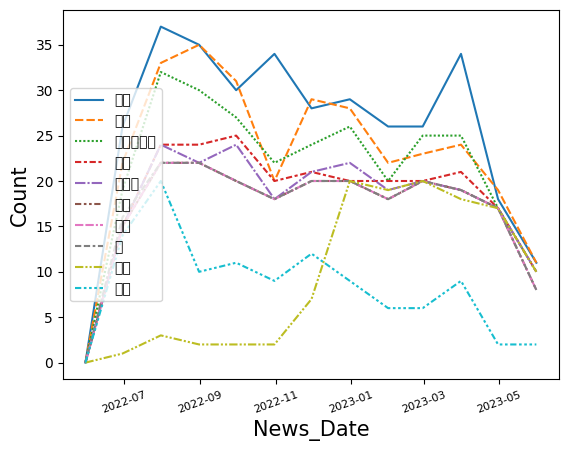

In [45]:
sns.lineplot(data=resampled_ten)

plt.xticks(fontsize = 8, rotation = 20) # x축
plt.xlabel('News_Date', fontsize = 15) # x축 이름
plt.ylabel('Count', fontsize = 15) # y축 이름

plt.show()

In [51]:
resampled.news_date

0    2022-05-31
1    2022-06-30
2    2022-07-31
3    2022-08-31
4    2022-09-30
5    2022-10-31
6    2022-11-30
7    2022-12-31
8    2023-01-31
9    2023-02-28
10   2023-03-31
11   2023-04-30
12   2023-05-31
Name: news_date, dtype: datetime64[ns]

In [47]:
# 날짜별 단어들의 집계수 - bar plot 
plt.rcParams['font.family'] = 'Malgun Gothic'



In [48]:
resampled_d = resampled.drop(labels=['news_date'], axis=1)
col_names = resampled_d.columns
col_names

Index(['코딩', '언어', '프로그래밍', '인기', '트렌드', '지수', '랭킹', '티', '순위', '개발',
       ...
       '디버깅', '기간', '포트', '상표', '대가', '초래', '프리뷰', '프랑스', '사물인터넷', '채무'],
      dtype='object', length=1457)

In [ ]:
# 각 feature와 target 간의 분포와 관계 살펴보기
target = resampled['news_date']

figure, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 100))
for i in range(len(col_names)-1):
    # ax.scatter(x축_data, y축_)
    fig = sns.barplot(data=resampled, x=target, y=col_names[i], ax = axes[i // 4, i % 4])
    fig.set_xlabel("Date")
    fig.set_ylabel(col_names[i])

In [60]:
all_word_df_ten = all_word_df.iloc[:10,:]
all_word_df_ten

,words,cnt
0,코딩,348
1,언어,303
2,프로그래밍,277
3,인기,238
4,트렌드,231
5,지수,219
6,랭킹,219
7,티,202
8,순위,121
9,개발,118


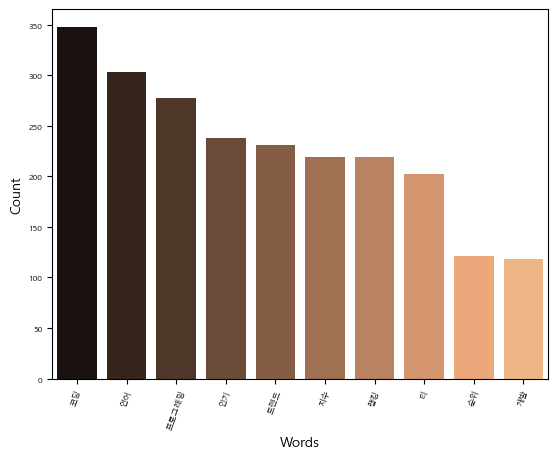

In [63]:
# 해당 기간 동안 각 단어 집계

target = all_word_df_ten['cnt']


fig = sns.barplot(data=all_word_df_ten, x=all_word_df_ten["words"], y=target, palette='copper')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 70)
fig.set_xlabel("Words")
fig.set_ylabel("Count")
plt.tick_params(axis='both', labelsize=6)

# all_word_df